## <font color="#59B4C3">📃&nbsp;&nbsp;Introduction</font>

Adapted from: https://keras.io/examples/generative/dcgan_overriding_train_step/

In this Practical Work you will look at an implementation of a Deep Convolutional Generative Adverserial Network, you will get to become familiar with adverserial training and the concept of latent space.

We will use Fashion MNIST dataset to train a model that will generate new clothes images. This dataset is small and easy enough to be trained on Google Colab.

## <font color="#59B4C3">🎯&nbsp;&nbsp;Your task</font>
As strange at it may be, **you don't need to modify code and to train any model in this practical work**. We already trained GANs for you to save you time. The important part is understanding the concepts shown and what is happening in this notebook.

If you still want to run the code, make sure you run it with GPU runtime (Runtime -> Change runtime type -> GPU). Otherwise it will take way longer!

## <font color="#59B4C3">⚙️&nbsp;&nbsp;Load and preprocess dataset</font>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

2025-02-26 15:35:04.971484: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/quentinsurdez/Admin/HEIG/BA5/MIN/Lab/Lab01/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def preprocess_image(image):
    image = tf.cast(image, tf.float32)

    # We scale values between [-1, 1]
    # Because we have a tanh output.
    image = (image - 127.5) / 127.5

    return image

In [3]:
train_images = fashion_mnist.load_data()[0][0]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
train_images = np.expand_dims(train_images, axis=-1)
train_images.shape

(60000, 28, 28, 1)

In [5]:
BATCH_SIZE = 512

train_dataset = tf.data.Dataset.from_tensor_slices(train_images) \
                  .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) \
                  .shuffle(8 * BATCH_SIZE) \
                  .batch(BATCH_SIZE) \
                  .prefetch(tf.data.AUTOTUNE)

## <font color="#59B4C3">🌆&nbsp;&nbsp; Visualize dataset</font>

2025-02-26 15:39:22.530859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


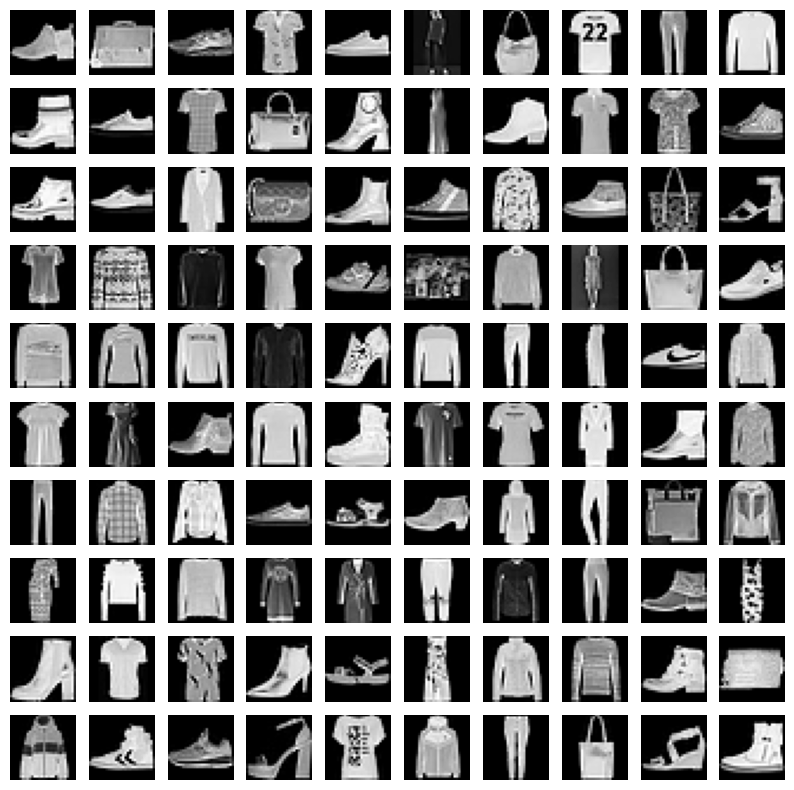

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images in train_dataset.take(1):
    for i in range(100):
        ax = plt.subplot(10, 10, i + 1)
        plt.imshow(np.uint8(images[i].numpy() * 127.5 + 127.5).squeeze(), cmap="gray")
        plt.axis("off")

### Questions 1.1

<pre>
<font color="#74E291">❓ What makes this practical work experiment a self-supervised one?
</pre>

<font color="#FFFFFF">
Answer: This practical work will transform the raw data without using explicit labels, creating a representation learning task where the model will have to learn meaningful pattern from the data itself. 

The emphasis is on the fact that none of the data will be labeled and that, using GAN, it will learn by itself from the data.


## <font color="#59B4C3">🏛&nbsp;&nbsp;Architecture</font>

## GANs

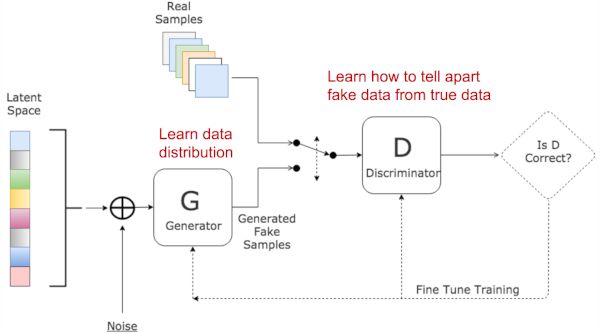

## Instability
GANs training is unstable because we train the generator and discriminator at the same time. When the generator improves, the discriminator will have a hard time to discrimate between real and fake samples, reciprocally if the discriminator improves the generator model will have difficulty to create samples that fool the discriminator.

So it means that the model will have trouble to converge.

To alleviate this issue we can help stabilize the GAN by following the architecture guidelines below.

![Deep Convolutional GAN architecture guidelines](https://machinelearningmastery.com/wp-content/uploads/2019/04/Summary-of-Architectural-Guidelines-for-Training-Stable-Deep-Convolutional-Generative-Adversarial-Networks-768x209.png)

\
## Guidelines explanations

You will find below a few explanations about concepts you may be unfamiliar with. This part is here to help you understand the new concepts you will encounter in the code. **Don't panick, it's not the core of this practical work ;)**

\
### Strided convolutions

Instead of using a pooling layer to get a smaller image (e.g. max pooling), we use a convolution with a stride. The stride is the size of the "jump" our filter make while moving. By default, a convolution has strides of one and as such the filter will shift one cell by one cell. With strides of two, we shift by two cells and because of that we will get an output of half the size.

You can see its effect interactively here: https://ezyang.github.io/convolution-visualizer/

\
### Fractional-strided convolutions

Also called transposed convolutions, they're kind of the inverse of a convolution: with them the stride  of the convolution is over the output instead of over the input, the padding (the values we add on the borders if the kernel has values outside the image) is also on the output. As such, we get a bigger output.

In Keras the layer is called **Conv2DTranspose**.

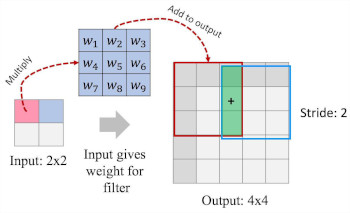

Note: it may cause some [visual artifacts](https://distill.pub/2016/deconv-checkerboard/).

\
### Batchnorm

Remember that in order to make learning easier for our model, we like to standardize features by having values centered around zero and standard deviation of one? Now consider that the inputs of a layer is the activations from the previous layer. So it might be a good idea to normalize the activations output and batch norm will to just that: it will learn how to normalize the activations by computing the mean and standard deviation across mini-batches and two parameters beta (which will shift values to a another mean) and gamma (which will scale values to a another variance).

The layer in Keras is: **BatchNormalization**.

![Normalization impact](https://miro.medium.com/v2/resize:fit:720/format:webp/1*AWUms56mCp8TksH9sYufrQ.png)

For further explanations see:

- https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739
- https://www.jeremyjordan.me/batch-normalization/
- https://e2eml.school/batch_normalization.html

\
### LeakyReLU

LeakyReLU is an activation function like ReLU but when x < 0 we multiply x by a constant contrary to ReLU where they are set to 0.

```
f(x) = alpha * x if x < 0
f(x) = x if x >= 0
```

![LeakyReLU](https://miro.medium.com/v2/resize:fit:720/0*xpidE6gRYdTBz9YJ)

Why yet another activation function? To fix the dying ReLU issue: "The dying ReLU refers to the problem when ReLU neurons become inactive and only output 0 for any input." ([Dying ReLU and Initialization: Theory and Numerical Examples](https://arxiv.org/pdf/1903.06733.pdf))

## <font color="#59B4C3">🧑‍🎨&nbsp;&nbsp;Create Generator</font>

In [10]:
from tensorflow import keras
from tensorflow.keras import layers,  activations

latent_dim = 128

init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),

        layers.Dense(7 * 7 * 256, kernel_initializer=init),
        layers.BatchNormalization(),
        layers.Activation(activations.relu),

        layers.Reshape((7, 7, 256)),

        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', kernel_initializer=init),
        layers.BatchNormalization(),
        layers.Activation(activations.relu),

        layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', kernel_initializer=init),
        layers.Activation(activations.tanh)
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,618,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 256)    │     1,048,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 1)      │         6,401 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,724,609 (10.39 MB)

 Trainable params: 2,699,009 (10.30 MB)

 Non-trainable params: 25,600 (100.00 KB)

### Questions 1.2

<pre>
<font color="#74E291">❓ Please look at the generator architecture.
How many time do we multiply by two the size of the input and what are the layers
responsible for this?

❓ What is the use of the Reshape layer in this code?
</pre>

<font color="#FFFFFF">
Answer: The generator increases the space dimensions of the input twice. This happens through the `Conv2DTranspose` layers. We can observe that initially our tensor is 7x7x256, the first `Conv2DTranspose` transforms it into a 14x14x256 tensor. It is thanks to the `strides=2` parameter. Then the same transformation happens with the second `Conv2DTranspose` where our 14x14x256 tensor transforms into a 28x28x256 tensor.
</br>

The `Reshape` layer serves as some kind of restructuration from the dense $7*7*256$ flat vector (dense layer) into a 3D tensor with spatial dimensions of 7x7 and 256 channels (convolutional layer). The will allow the `Conv2DTranspose` layers to work properlly and is the starting point for the upsampling of the images.

## <font color="#59B4C3">🔍&nbsp;&nbsp;Visualize Generator Input/Output</font>

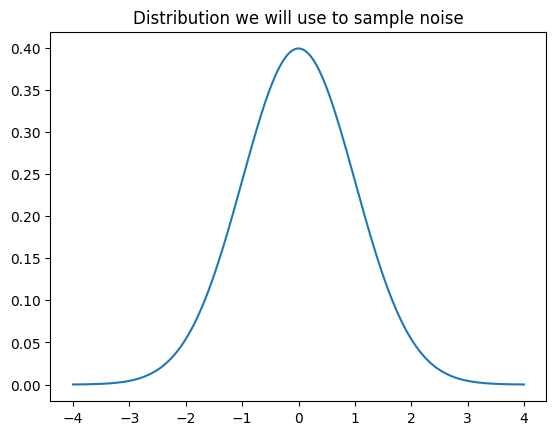

noise example: [[-0.4816996   0.9358426   0.80670613  0.45455983 -0.88438845  0.2839622
  -0.63050723 -0.36225095 -0.7499337   1.1191764  -0.69550294  0.5027417
   0.34934625  0.25185326 -0.47050908  1.7825986   1.186483    0.717073
   0.18563588 -1.7507187  -1.1781784   1.5952054   0.8832985   0.6966448
   2.1735327   1.3122239  -0.30466646  1.3054787   0.5420747   0.06583939
  -0.19751745 -0.2505102  -0.67582256 -0.05355482  1.2148321   0.49713418
  -1.0606902   2.5178182   0.8011122   0.44115806 -0.06584585  0.49666023
   0.11458828  1.4366868  -0.58992714 -1.0388185  -1.7966185  -2.2241144
   1.1100652  -1.5875638   0.16883303 -0.14632149 -0.91950494  1.3899652
  -2.7073057  -0.06837644 -0.9309415  -0.12239569  0.01711645  0.13272133
  -1.7158211   0.05193841 -0.63990754  0.9091686  -0.16998401 -1.1384649
  -0.02547542  0.09086749 -0.44983155 -0.11704792  0.17460771 -2.002988
   2.3777235  -0.9772428   0.05452461  1.3611007  -0.48851278  0.81624323
   0.44414043 -0.85974467 -0.5204

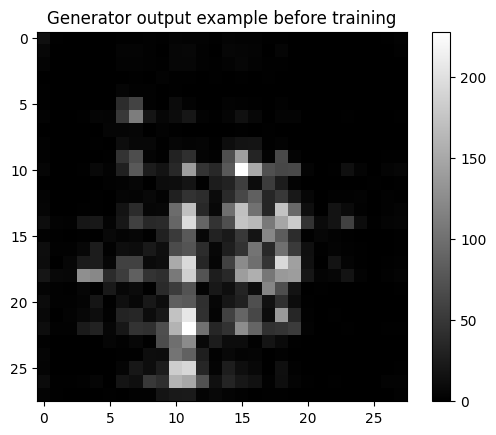

Num GPUs Available:  0


In [ ]:
normal_mean = 0.0
normal_stddev = 1.0

# Distribution we will use to sample noise
import numpy as np
from scipy.stats import norm

x_axis = np.arange(-4, 4, 0.001)
plt.title("Distribution we will use to sample noise")
plt.plot(x_axis, norm.pdf(x_axis, normal_mean, normal_stddev))
plt.show()

# Noise example
random_latent_vectors = tf.random.normal(shape=(1, latent_dim), mean=normal_mean, stddev=normal_stddev)
print(f"noise example: {random_latent_vectors}")

# Generator output example before training
generator_output_example = generator(random_latent_vectors)[0]

plt.title("Generator output example before training")
plt.imshow(np.uint8(generator_output_example.numpy() * 127.5 + 127.5).squeeze(), cmap="gray")
plt.colorbar()
plt.show()

## <font color="#59B4C3">🕵️&nbsp;&nbsp;Create Discriminator</font>


In [13]:
from tensorflow.keras import Input, Sequential, layers

init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

discriminator = Sequential(
    [
        Input(shape=(28, 28, 1)),

        layers.Conv2D(64, kernel_size=4, strides=2, padding="same", kernel_initializer=init),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(128, kernel_size=4, strides=2, padding="same", kernel_initializer=init),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(256, kernel_size=4, strides=2, padding="same", kernel_initializer=init),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid", kernel_initializer=init),
    ],
    name="discriminator",
)
discriminator.summary()

/Users/quentinsurdez/Admin/HEIG/BA5/MIN/Lab/Lab01/.venv/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 662,721 (2.53 MB)

 Trainable params: 661,825 (2.52 MB)

 Non-trainable params: 896 (3.50 KB)

### Questions 1.3

<pre>
<font color="#74E291">❓ Please look at the discriminator architecture, notices that it's a CNN classifier (between fake and real images).
If you where to classify RGB images of multiple animal classes (cats, dogs and ducks for example),
what would you need to change?
</pre>

Answer: There are numerous change to make

## <font color="#59B4C3">🪄&nbsp;&nbsp;Create Deep Convolutional Gan</font>


In [14]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [15]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import array_to_img

class GANMonitor(Callback):
    def __init__(self, latent_dim=128):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        n_images = 4

        random_latent_vectors = tf.random.normal(shape=(4, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = np.uint8(generated_images.numpy() * 127.5 + 127.5)

        fig, axs = plt.subplots(2, 2, figsize=(3, 3))

        for i in range(n_images):
            plt.subplot(2, 2, i+1)
            plt.axis("off")
            plt.imshow(generated_images[i].squeeze(), cmap="gray")

        plt.show()

## <font color="#59B4C3">🚀&nbsp;&nbsp;Train DCGAN</font>

Here's how you train it.

Epoch 1/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - d_loss: 0.4961 - g_loss: 1.0067

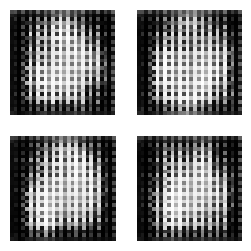

118/118 ━━━━━━━━━━━━━━━━━━━━ 400s 3s/step - d_loss: 0.4959 - g_loss: 1.0095
Epoch 2/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - d_loss: 0.4165 - g_loss: 1.7750

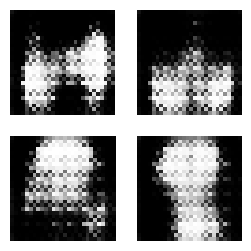

118/118 ━━━━━━━━━━━━━━━━━━━━ 542s 5s/step - d_loss: 0.4172 - g_loss: 1.7733
Epoch 3/40
 27/118 ━━━━━━━━━━━━━━━━━━━━ 5:49 4s/step - d_loss: 0.6279 - g_loss: 1.0208

KeyboardInterrupt: 

In [16]:
epochs = 40

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    train_dataset, epochs=epochs, callbacks=[GANMonitor(latent_dim=latent_dim)]
)

In [ ]:
import matplotlib.pyplot as plt

discriminator_loss = history.history['d_loss']
generator_loss = history.history['g_loss']

plt.plot(history.history['d_loss'], label="Discriminator loss")
plt.plot(history.history['g_loss'], label="Generator loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()